# Multimodal Fusion for Pulmonary Embolism Classification

In this demonstration, we will build a multimodal fusion model (late fusion) that combines information from both CT scans and Electronic Medical Record (EMR) to automatically diagnose the presence of PE. 

### Motivation

Pulmonary Embolism (PE) is a serious medical condition that hospitalizes 300,000 people in the United States every year. The gold standard diagnostic modality for PE is Computed Tomography Pulmonary Angiography (CTPA) which is interpreted by radiologists. Studies have shown that prompt diagnosis and treatment can greatly reduce morbidity and mortality. Strategies to automate accurate interpretation and timely reporting of CTPA examinations may successfully triage urgent cases of PE to the immediate attention of physicians, improving time to diagnosis and treatment.

Recent advancements in deep learning have led to a resurgence of medical imaging and Electronic Medical Record (EMR) models for a variety of applications, including clinical decision support, automated workflow triage, clinical prediction and more. However, very few models have been developed to integrate both clinical and imaging data, despite that in routine practice clinicians rely on EMR to provide context in medical imaging interpretation. 

### Data
We will use RadFusion, a large-scale multimodal pulmonary embolism detection dataset consisting of 1837 CT imaging studies (comprising 600,000+ 2D slices) for 1794 patients and their corresponding EHR summary data. 

### References
- Huang, Shih-Cheng, et al. "PENet—a scalable deep-learning model for automated diagnosis of pulmonary embolism using volumetric CT imaging." NPJ digital medicine 3.1 (2020): 1-9.
- Huang, Shih-Cheng, et al. "Multimodal fusion with deep neural networks for leveraging CT imaging and electronic health record: a case-study in pulmonary embolism detection." Scientific reports 10.1 (2020): 1-9.

## System Setup & Downloading the Data

In [1]:
!pip install numpy pandas scikit-learn matplotlib
!gdown --id 1w0ocK3br8oqVwn6zK5qgtRaj9Ql37dtd  # /content/Demographics.csv
!gdown --id 1MEhVZ87J2IwFmkgxOi8WjdVKTdwOpDDY  # /content/INP_MED.csv
!gdown --id 1PRgFvQjqEUudeJ0FLR3DbtvqmI7t7sCT  # /content/OUT_MED.csv
!gdown --id 1EDZOYmWrvv6D3XaZrjVous95c9HdiBEx  # /content/Vitals.csv
!gdown --id 1Nlm1ZgibRv6kJBIJkQHkRh8oPqUpELnK  # /content/ICD.csv
!gdown --id 17Y9DJsolaRPyMkk_Xm3w-iCgSOxkQOyf  # /content/LABS.csv
!gdown --id 1dp_L_YxYgxUHVV1F50vIlNTX1m7FBSqW  # /content/Vision.csv

Downloading...
From: https://drive.google.com/uc?id=1w0ocK3br8oqVwn6zK5qgtRaj9Ql37dtd
To: /content/Demographics.csv
100% 59.8k/59.8k [00:00<00:00, 6.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MEhVZ87J2IwFmkgxOi8WjdVKTdwOpDDY
To: /content/INP_MED.csv
100% 4.77M/4.77M [00:00<00:00, 75.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PRgFvQjqEUudeJ0FLR3DbtvqmI7t7sCT
To: /content/OUT_MED.csv
100% 4.79M/4.79M [00:00<00:00, 75.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EDZOYmWrvv6D3XaZrjVous95c9HdiBEx
To: /content/Vitals.csv
100% 97.1k/97.1k [00:00<00:00, 28.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nlm1ZgibRv6kJBIJkQHkRh8oPqUpELnK
To: /content/ICD.csv
100% 1.06M/1.06M [00:00<00:00, 63.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=17Y9DJsolaRPyMkk_Xm3w-iCgSOxkQOyf
To: /content/LABS.csv
100% 266k/266k [00:00<00:00, 65.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dp_L_YxYgxUHVV1F50vIlNTX1m7FBSqW
To: /co

After downloading the data, you should be able to find the following files in your directory: 
    
- **Demographics.csv**: one-hot encoded gender, race and smoking habits and the age as a numeric variable.
- **INP_MED.csv**: 641 unique classes of drugs represented as both the frequency within the 12-month window and a binary label of whether the drug was prescribed to the patient. 
- **OUT_MED.csv**: similar to (INPT_MED) inpatient medications, but for out patients
- **Vitals.csv**: including systolic and diastolic blood pressure, height, weight, body mass index (BMI), temperature, respiration rate, pulse oximetry (spO2) and heart rate.
- **ICD.csv**: 141 diagnosis groups presented as binary presence/absence as well as a frequency.
- **LABS.csv**: 22 lab tests represented as binary presence/absence as well as the latest value
- **Vision.csv**: PE labels, PE type, Data split for PENet, PENet prediction probablity

## Explore Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Patient Demographics
demo_df = pd.read_csv('/content//Demographics.csv')
print(demo_df.shape)
demo_df.head(5)

(1837, 13)


,idx,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,SMOKER_N,SMOKER_Y
0,890,80.00,1,0,0,0,0,0,0,0,1,1,0
1,1879,64.12,0,1,0,0,0,0,0,0,1,0,1
2,1783,93.42,0,1,0,0,0,0,0,0,1,0,1
3,3896,93.82,1,0,0,0,0,0,0,0,1,1,0
4,1193,71.78,1,0,0,0,0,0,0,0,1,1,0


In [4]:
out_med_df = pd.read_csv('/content//OUT_MED.csv')
print(out_med_df.shape)
out_med_df.head(5)

(1837, 1283)


,idx,"Outpatient_LAXATIVES, LOCAL/RECTAL:Binary",Outpatient_PLATELET AGGREGATION INHIBITORS:Binary,Outpatient_nan:Binary,"Outpatient_NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","Outpatient_ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",Outpatient_ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,Outpatient_SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"Outpatient_VASODILATORS,CORONARY:Binary",Outpatient_ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,Outpatient_BETA-ADRENERGIC BLOCKING AGENTS:Binary,Outpatient_HEPARIN AND RELATED PREPARATIONS:Binary,Outpatient_MAGNESIUM SALTS REPLACEMENT:Binary,Outpatient_ALPHA/BETA-ADRENERGIC BLOCKING AGENTS:Binary,Outpatient_ANTIARRHYTHMICS:Binary,"Outpatient_ANALGESICS, NARCOTICS:Binary",Outpatient_TOPICAL LOCAL ANESTHETICS:Binary,Outpatient_LOOP DIURETICS:Binary,Outpatient_NARCOTIC ANTAGONISTS:Binary,Outpatient_LIPOTROPICS:Binary,"Outpatient_SEDATIVE-HYPNOTICS,NON-BARBITURATE:Binary","Outpatient_ANTICOAGULANTS,COUMARIN TYPE:Binary",Outpatient_CALCIUM CHANNEL BLOCKING AGENTS:Binary,"Outpatient_NSAIDS, CYCLOOXYGENASE INHIBITOR - TYPE ANALGESICS:Binary",Outpatient_PROTON-PUMP INHIBITORS:Binary,Outpatient_BENIGN PROSTATIC HYPERTROPHY/MICTURITION AGENTS:Binary,Outpatient_POTASSIUM SPARING DIURETICS IN COMBINATION:Binary,Outpatient_GRAM POSITIVE COCCI VACCINES:Binary,Outpatient_ANTIHISTAMINES - 1ST GENERATION:Binary,Outpatient_LAXATIVES AND CATHARTICS:Binary,"Outpatient_ANALGESIC/ANTIPYRETICS, SALICYLATES:Binary",Outpatient_CEPHALOSPORINS - 3RD GENERATION:Binary,Outpatient_IV SOLUTIONS: DEXTROSE-WATER:Binary,Outpatient_VITAMIN C PREPARATIONS:Binary,Outpatient_ANTIDIARRHEAL MICROORGANISMS AGENTS:Binary,Outpatient_QUINOLONES:Binary,Outpatient_NARCOTIC ANALGESIC AND NON-SALICYLATE ANALGESIC:Binary,Outpatient_HISTAMINE H2-RECEPTOR INHIBITORS:Binary,Outpatient_ALPHA-2 RECEPTOR ANTAGONIST ANTIDEPRESSANTS:Binary,Outpatient_LOCAL ANESTHETICS:Binary,...,Outpatient_ANTIFUNGAL-LOCAL ANESTHETIC-ANTIHISTAMINE COMB:Frequeny,"Outpatient_METABOLIC DISEASE ENZYME REPLACEMENT, FABRY'S DX:Frequeny",Outpatient_ANTIPORPHYRIA FACTORS:Frequeny,"Outpatient_ANALGESIC, NON-SALICYLATE AND BARBITURATE COMBINAT:Frequeny",Outpatient_NEEDLES/NEEDLELESS DEVICES:Frequeny,"Outpatient_DIABETIC ULCER PREPARATIONS,TOPICAL:Frequeny",Outpatient_NON-NARCOTIC ANTITUSSIVE-ANALGESIC COMBINATIONS:Frequeny,"Outpatient_ANALGESIC,NON-SALICYLATE-1ST GEN ANTIHIST-XANTHINE:Frequeny","Outpatient_RENIN INHIBITOR,DIRECT-ANGIOTENSIN RECEPTR ANTAGON:Frequeny","Outpatient_CONTACT LENS PREPARATIONS(GAS,HARD,SOFT):Frequeny",Outpatient_ABORTIFACIENT-PROGESTERONE RECEPTOR ANTAGONISTS:Frequeny,Outpatient_PANTHENOL PREPARATIONS:Frequeny,Outpatient_NON-NARCOTIC ANTITUSSIVE-DECONGESTANT-ANALGESIC CB:Frequeny,"Outpatient_CONTRACEPTIVES, INTRAVAGINAL, SYSTEMIC:Frequeny",Outpatient_NON-NARC ANTITUSS-1ST GEN ANTIHIST-ANALGESIC COMB.:Frequeny,Outpatient_SUPPORT HOSIERY:Frequeny,"Outpatient_DIURETICS,MISCELLANEOUS:Frequeny","Outpatient_MEDICAL SUPPLIES,MISCELLANEOUS:Frequeny",Outpatient_ANGIOTEN.RECEPTR ANTAG-CALCIUM CHANL BLKR-THIAZIDE:Frequeny,Outpatient_TX FOR ADHD - SELECTIVE ALPHA-2 RECEPTOR AGONIST:Frequeny,"Outpatient_JOINT CONTRACTURE THERAPY, COLLAGENASE ENZYME:Frequeny",Outpatient_OPHTHALMIC ANTIFUNGAL AGENTS:Frequeny,Outpatient_AGENTS FOR STOMATOLOGICAL USE:Frequeny,Outpatient_NASAL WASHES:Frequeny,Outpatient_MENOPAUSAL SYMPT SUPP-SEL ESTROGEN RECEP MODULATOR:Frequeny,Outpatient_FOLLICLE-STIMULATING HORMONE (FSH):Frequeny,"Outpatient_LHRH(GNRH) ANTAGONIST,PITUITARY SUPPRESSANT AGENTS:Frequeny",Outpatient_HUMAN CHORIONIC GONADOTROPIN (HCG):Frequeny,"Outpatient_ALZHEIMER'S THX,NMDA RECEPTOR ANTAG-CHOLINES INHIB:Frequeny","Outpatient_ANTI-INFLAMMATORY,PHOSPHODIESTERASE-4(PDE4) INHIB.:Frequeny",Outpatient_LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,Outpatient_THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,Outpatient_SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,Outpatient_ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,Ou

In [5]:
in_med_df = pd.read_csv('/content/INP_MED.csv')
print(in_med_df.shape)
in_med_df.head(5)

(1837, 1283)


,idx,"LAXATIVES, LOCAL/RECTAL:Binary",PLATELET AGGREGATION INHIBITORS:Binary,nan:Binary,"NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"VASODILATORS,CORONARY:Binary",ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,BETA-ADRENERGIC BLOCKING AGENTS:Binary,HEPARIN AND RELATED PREPARATIONS:Binary,MAGNESIUM SALTS REPLACEMENT:Binary,ALPHA/BETA-ADRENERGIC BLOCKING AGENTS:Binary,ANTIARRHYTHMICS:Binary,"ANALGESICS, NARCOTICS:Binary",TOPICAL LOCAL ANESTHETICS:Binary,LOOP DIURETICS:Binary,NARCOTIC ANTAGONISTS:Binary,LIPOTROPICS:Binary,"SEDATIVE-HYPNOTICS,NON-BARBITURATE:Binary","ANTICOAGULANTS,COUMARIN TYPE:Binary",CALCIUM CHANNEL BLOCKING AGENTS:Binary,"NSAIDS, CYCLOOXYGENASE INHIBITOR - TYPE ANALGESICS:Binary",PROTON-PUMP INHIBITORS:Binary,BENIGN PROSTATIC HYPERTROPHY/MICTURITION AGENTS:Binary,POTASSIUM SPARING DIURETICS IN COMBINATION:Binary,GRAM POSITIVE COCCI VACCINES:Binary,ANTIHISTAMINES - 1ST GENERATION:Binary,LAXATIVES AND CATHARTICS:Binary,"ANALGESIC/ANTIPYRETICS, SALICYLATES:Binary",CEPHALOSPORINS - 3RD GENERATION:Binary,IV SOLUTIONS: DEXTROSE-WATER:Binary,VITAMIN C PREPARATIONS:Binary,ANTIDIARRHEAL MICROORGANISMS AGENTS:Binary,QUINOLONES:Binary,NARCOTIC ANALGESIC AND NON-SALICYLATE ANALGESIC:Binary,HISTAMINE H2-RECEPTOR INHIBITORS:Binary,ALPHA-2 RECEPTOR ANTAGONIST ANTIDEPRESSANTS:Binary,LOCAL ANESTHETICS:Binary,...,ANTIFUNGAL-LOCAL ANESTHETIC-ANTIHISTAMINE COMB:Frequeny,"METABOLIC DISEASE ENZYME REPLACEMENT, FABRY'S DX:Frequeny",ANTIPORPHYRIA FACTORS:Frequeny,"ANALGESIC, NON-SALICYLATE AND BARBITURATE COMBINAT:Frequeny",NEEDLES/NEEDLELESS DEVICES:Frequeny,"DIABETIC ULCER PREPARATIONS,TOPICAL:Frequeny",NON-NARCOTIC ANTITUSSIVE-ANALGESIC COMBINATIONS:Frequeny,"ANALGESIC,NON-SALICYLATE-1ST GEN ANTIHIST-XANTHINE:Frequeny","RENIN INHIBITOR,DIRECT-ANGIOTENSIN RECEPTR ANTAGON:Frequeny","CONTACT LENS PREPARATIONS(GAS,HARD,SOFT):Frequeny",ABORTIFACIENT-PROGESTERONE RECEPTOR ANTAGONISTS:Frequeny,PANTHENOL PREPARATIONS:Frequeny,NON-NARCOTIC ANTITUSSIVE-DECONGESTANT-ANALGESIC CB:Frequeny,"CONTRACEPTIVES, INTRAVAGINAL, SYSTEMIC:Frequeny",NON-NARC ANTITUSS-1ST GEN ANTIHIST-ANALGESIC COMB.:Frequeny,SUPPORT HOSIERY:Frequeny,"DIURETICS,MISCELLANEOUS:Frequeny","MEDICAL SUPPLIES,MISCELLANEOUS:Frequeny",ANGIOTEN.RECEPTR ANTAG-CALCIUM CHANL BLKR-THIAZIDE:Frequeny,TX FOR ADHD - SELECTIVE ALPHA-2 RECEPTOR AGONIST:Frequeny,"JOINT CONTRACTURE THERAPY, COLLAGENASE ENZYME:Frequeny",OPHTHALMIC ANTIFUNGAL AGENTS:Frequeny,AGENTS FOR STOMATOLOGICAL USE:Frequeny,NASAL WASHES:Frequeny,MENOPAUSAL SYMPT SUPP-SEL ESTROGEN RECEP MODULATOR:Frequeny,FOLLICLE-STIMULATING HORMONE (FSH):Frequeny,"LHRH(GNRH) ANTAGONIST,PITUITARY SUPPRESSANT AGENTS:Frequeny",HUMAN CHORIONIC GONADOTROPIN (HCG):Frequeny,"ALZHEIMER'S THX,NMDA RECEPTOR ANTAG-CHOLINES INHIB:Frequeny","ANTI-INFLAMMATORY,PHOSPHODIESTERASE-4(PDE4) INHIB.:Frequeny",LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,FEEDING DEVICES:Frequeny,"DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","ACNE AGENTS,SYSTEMIC:Frequeny"
0,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1691,1,1,0,0,1,0,0,0,1

In [6]:
icd_df = pd.read_csv('/content/ICD.csv')
print(icd_df.shape)
icd_df.head(5)

(1837, 283)


,idx,MATERNAL CAUSES OF PERINATAL MORBIDITY AND MORTALITY:frequency,OTHER CONDITIONS ORIGINATING IN THE PERINATAL PERIOD:frequency,COMPLICATIONS MAINLY RELATED TO PREGNANCY:frequency,COMPLICATIONS OCCURRING MAINLY IN THE COURSE OF LABOR AND DELIVERY:frequency,COMPLICATIONS OF THE PUERPERIUM:frequency,ECTOPIC AND MOLAR PREGNANCY:frequency,"NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY:frequency",OTHER MATERNAL AND FETAL COMPLICATIONS:frequency,OTHER PREGNANCY WITH ABORTIVE OUTCOME:frequency,Anencephalus and similar anomalies:frequency,"Anomalies of respiratory system, congenital:frequency",Bulbus cordis anomalies and anomalies of cardiac septal closure:frequency,Certain congenital musculoskeletal deformities:frequency,Chromosomal anomalies:frequency,Cleft palate and cleft lip:frequency,"Congenital anomalies of ear, face, and neck:frequency",Congenital anomalies of eye:frequency,Congenital anomalies of genital organs:frequency,Congenital anomalies of the integument:frequency,Congenital anomalies of urinary system:frequency,Other and unspecified congenital anomalies:frequency,Other congenital anomalies of circulatory system:frequency,Other congenital anomalies of digestive system:frequency,Other congenital anomalies of heart:frequency,Other congenital anomalies of limbs:frequency,Other congenital anomalies of nervous system:frequency,Other congenital anomalies of upper alimentary tract:frequency,Other congenital musculoskeletal anomalies:frequency,Spina bifida:frequency,Acquired hemolytic anemias:frequency,Aplastic anemia and other bone marrow failure syndromes:frequency,Coagulation defects:frequency,Diseases of white blood cells:frequency,Hereditary hemolytic anemias:frequency,Iron deficiency anemias:frequency,Other and unspecified anemias:frequency,Other deficiency anemias:frequency,Other diseases of blood and blood-forming organs:frequency,Purpura and other hemorrhagic conditions:frequency,...,TUBERCULOSIS:presence,VIRAL DISEASES GENERALLY ACCOMPANIED BY EXANTHEM:presence,ZOONOTIC BACTERIAL DISEASES:presence,BURNS:presence,CERTAIN TRAUMATIC COMPLICATIONS AND UNSPECIFIED INJURIES:presence,"COMPLICATIONS OF SURGICAL AND MEDICAL CARE, NOT ELSEWHERE CLASSIFIED:presence",CONTUSION WITH INTACT SKIN SURFACE:presence,CRUSHING INJURY:presence,DISLOCATION:presence,EFFECTS OF FOREIGN BODY ENTERING THROUGH ORIFICE:presence,FRACTURES:presence,INJURY TO BLOOD VESSELS:presence,INJURY TO NERVES AND SPINAL CORD:presence,"INTERNAL INJURY OF THORAX, ABDOMEN, AND PELVIS:presence","INTRACRANIAL INJURY, EXCLUDING THOSE WITH SKULL FRACTURE:presence","LATE EFFECTS OF INJURIES, POISONINGS, TOXIC EFFECTS, AND OTHER EXTERNAL CAUSES:presence",OPEN WOUNDS:presence,OTHER AND UNSPECIFIED EFFECTS OF EXTERNAL CAUSES:presence,"POISONING BY DRUGS, MEDICINAL AND BIOLOGICAL SUBSTANCES:presence",SPRAINS AND STRAINS OF JOINTS AND ADJACENT MUSCLES:presence,SUPERFICIAL INJURY:presence,TOXIC EFFECTS OF SUBSTANCES CHIEFLY NONMEDICINAL AS TO SOURCE:presence,INTELLECTUAL DISABILITIES:presence,"NEUROTIC DISORDERS, PERSONALITY DISORDERS, AND OTHER NONPSYCHOTIC MENTAL DISORDERS:presence",PSYCHOSES:presence,NEOPLASMS:presence,ILL-DEFINED AND UNKNOWN CAUSES OF MORBIDITY AND MORTALITY:presence,NONSPECIFIC ABNORMAL FINDINGS:presence,General symptoms:presence,Other symptoms involving abdomen and pelvis:presence,"Symptoms concerning nutrition, metabolism, and development:presence",Symptoms involving cardiovascular system:presence,Symptoms involving digestive system:presence,Symptoms involving head and neck:presence,Symptoms involving nervous and musculoskeletal systems:presence,Symptoms involving respiratory system and other chest symptoms:presence,Symptoms involving skin and other integumentary tissue:presence,Symptoms involving urinary system:presence,SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING:presence,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES:presence
0,84,

In [7]:
lab_df = pd.read_csv('/content/LABS.csv')
print(lab_df.shape)
lab_df.head(5)

(1837, 45)


,idx,albumin:Binary,alk:Binary,ast:Binary,anion:Binary,bilirubin:Binary,bun:Binary,bun_cre:Binary,calcium:Binary,creatinine:Binary,d-dimer:Binary,glucose:Binary,nan:Binary,hemoglobin:Binary,a1c:Binary,hgb:Binary,inr:Binary,lactate:Binary,platelet:Binary,potassium:Binary,ptt:Binary,sodium:Binary,wbc:Binary,albumin:Value,alk:Value,ast:Value,anion:Value,bilirubin:Value,bun:Value,bun_cre:Value,calcium:Value,creatinine:Value,d-dimer:Value,glucose:Value,nan:Value,hemoglobin:Value,a1c:Value,hgb:Value,inr:Value,lactate:Value,platelet:Value,potassium:Value,ptt:Value,sodium:Value,wbc:Value
0,84,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,2.6,51.0,15.0,6.0,0.8,12.0,0.0,0.0,1.00,0.0,148.0,0,7.9,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.3
1,2248,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,4.4,60.0,24.0,7.0,1.3,11.0,0.0,0.0,0.93,0.0,88.0,0,12.4,0.0,0.0,0.0,0.0,655.0,0.0,0.0,0.0,13.8
2,2271,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,2.6,75.0,22.0,7.0,0.5,14.0,0.0,0.0,1.20,0.0,123.0,0,10.9,0.0,0.0,1.3,0.0,356.0,0.0,15.9,0.0,6.8
3,1691,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,3.0,117.0,71.0,12.0,0.6,23.0,0.0,0.0,1.30,0.0,126.0,0,11.7,0.0,0.0,0.0,1.8,426.0,0.0,0.0,0.0,10.0
4,3286,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,3.2,64.0,28.0,8.0,0.5,12.0,0.0,0.0,0.70,0.0,91.0,0,12.7,0.0,0.0,2.0,0.0,131.0,0.0,21.7,0.0,4.0


In [8]:
vitals_df = pd.read_csv('/content/Vitals.csv')
vitals_df.head(5)

,idx,SBP,DBP,height_inch,weight_kg,bmi,tempf,respirations,spO2,pulse
0,84,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
1,2248,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
2,2271,0.0,-7.0,-48.5,-5.65,-38.985,44.30,-28.5,5.0,12.0
3,1691,5.0,0.0,-48.0,-1.90,-37.850,43.05,-28.5,4.5,18.0
4,3286,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0


In [9]:
vision_df = pd.read_csv('/content/Vision.csv')
vision_df.head(5)

,idx,label,pred,pe_type,split
0,1436,0,0.405236,segmental,train
1,1880,1,0.836337,segmental,train
2,2738,0,0.596504,central,val
3,2883,0,0.108968,segmental,train
4,2302,1,0.808755,segmental,train


## Process Data

In [10]:
processed_emr_dfs = []
for df in [demo_df, out_med_df, in_med_df, icd_df, lab_df, vitals_df]:
    # remove zero variance featurs
    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    # set index 
    df = df.set_index('idx')

    # normalize features
    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_emr_dfs.append(df)

emr_df = pd.concat(processed_emr_dfs, axis=1)
emr_df.head(5)

,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,SMOKER_N,SMOKER_Y,"Outpatient_LAXATIVES, LOCAL/RECTAL:Binary",Outpatient_PLATELET AGGREGATION INHIBITORS:Binary,"Outpatient_NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","Outpatient_ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",Outpatient_ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,Outpatient_SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"Outpatient_VASODILATORS,CORONARY:Binary",Outpatient_ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,Outpatient_BETA-ADRENERGIC BLOCKING AGENTS:Binary,Outpatient_HEPARIN AND RELATED PREPARATIONS:Binary,Outpatient_MAGNESIUM SALTS REPLACEMENT:Binary,Outpatient_ALPHA/BETA-ADRENERGIC BLOCKING AGENTS:Binary,Outpatient_ANTIARRHYTHMICS:Binary,"Outpatient_ANALGESICS, NARCOTICS:Binary",Outpatient_TOPICAL LOCAL ANESTHETICS:Binary,Outpatient_LOOP DIURETICS:Binary,Outpatient_LIPOTROPICS:Binary,"Outpatient_SEDATIVE-HYPNOTICS,NON-BARBITURATE:Binary","Outpatient_ANTICOAGULANTS,COUMARIN TYPE:Binary",Outpatient_CALCIUM CHANNEL BLOCKING AGENTS:Binary,"Outpatient_NSAIDS, CYCLOOXYGENASE INHIBITOR - TYPE ANALGESICS:Binary",Outpatient_PROTON-PUMP INHIBITORS:Binary,Outpatient_BENIGN PROSTATIC HYPERTROPHY/MICTURITION AGENTS:Binary,Outpatient_POTASSIUM SPARING DIURETICS IN COMBINATION:Binary,Outpatient_GRAM POSITIVE COCCI VACCINES:Binary,Outpatient_ANTIHISTAMINES - 1ST GENERATION:Binary,Outpatient_LAXATIVES AND CATHARTICS:Binary,"Outpatient_ANALGESIC/ANTIPYRETICS, SALICYLATES:Binary",...,hemoglobin:Binary,a1c:Binary,hgb:Binary,inr:Binary,lactate:Binary,platelet:Binary,potassium:Binary,ptt:Binary,sodium:Binary,wbc:Binary,albumin:Value,alk:Value,ast:Value,anion:Value,bilirubin:Value,bun:Value,bun_cre:Value,calcium:Value,creatinine:Value,d-dimer:Value,glucose:Value,hemoglobin:Value,a1c:Value,hgb:Value,inr:Value,lactate:Value,platelet:Value,potassium:Value,ptt:Value,sodium:Value,wbc:Value,SBP,DBP,height_inch,weight_kg,bmi,tempf,respirations,spO2,pulse
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.141129,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,2.623046,-1.215844,0.477302,-0.477302,-0.112571,-0.201918,-0.033005,-0.191473,-0.22955,-0.147238,-0.096621,-0.216098,-0.206257,-0.248628,-0.061831,-0.099449,-0.099449,-0.233464,-0.099449,-0.167226,-0.137285,-0.170634,-0.213325,-0.175634,-0.1789,-0.263114,-0.096621,-0.057229,-0.023332,-0.137285,-0.295936,-0.124377,...,0.263114,-0.310908,-0.040434,-1.717245,-0.547638,0.266643,-0.09371,-1.697690,-0.183702,0.264294,0.120675,1.041790,-0.195285,0.374543,-0.304271,-0.275628,-0.310886,-0.09908,-0.053353,-0.349034,0.225052,-1.241959,-0.304419,-0.040144,-0.572409,-0.023332,-0.089195,-0.093491,-0.900556,-0.024684,-0.068430,0.099003,0.101052,0.590589,0.497322,0.560919,0.250621,0.304327,0.344230,0.290821
1,-1.176230,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,0.477302,-0.477302,-0.112571,-0.201918,-0.033005,-0.191473,-0.22955,-0.147238,-0.096621,-0.216098,-0.206257,-0.248628,-0.061831,-0.099449,-0.099449,-0.233464,-0.099449,-0.167226,-0.137285,-0.170634,-0.213325,-0.175634,-0.1789,-0.263114,-0.096621,-0.057229,-0.023332,-0.137285,-0.295936,-0.124377,...,0.263114,-0.310908,-0.040434,0.582011,-0.547638,0.266643,-0.09371,0.588715,-0.183702,0.264294,0.874325,-0.351539,0.014773,0.374543,0.626658,0.229690,-0.310886,-0.09908,-0.053353,-0.349034,-0.141409,-0.079819,-0.304419,-0.040144,0.127782,-0.023332,-0.131606,-0.093491,0.278929,-0.024684,-0.069198,0.082765,0.076690,-1.697669,0.501981,-1.786694,0.286399,0.283688,0.346826,0.290449
2,-1.176230,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,0.477302,-0.477302,-0.112571,-0.201918,-0.033005,-0.191473,-0.22955,-0.147238,-0.096621,-0.216098,-0.206257,-0.248628,-0.061831,-0.099449,-0.099449,-0.233464,-0.099449,-0.167226,-0.137285,-0.170634,-0.213325,-0.175634,-0.1789,-0.263114,-0.096621,-0.057229,-0.0

In [11]:
# Define columns
EMR_FEATURE_COLS = emr_df.columns.tolist()
PE_TYPE_COL = 'pe_type'
SPLIT_COL = 'split'
VISION_PRED_COL = 'pred'
EMR_PRED_COL = 'emr_pred'
FUSION_PRED_COL = 'late_fusion_pred'
LABEL_COL = 'label'

In [12]:
# Join vision information with emr dataframe
vision_df = vision_df.set_index('idx')
df = pd.concat([vision_df, emr_df], axis=1)

In [13]:
# Create data splits
df_dev = df[(df.split == 'train') | (df.split == 'val')]  # for gridsearch CV
df_train = df[df.split == 'train']
df_val = df[df.split == 'val']
df_test = df[df.split == 'test']

## [Option 1] Train EMR Model with Grid Search



## Train EMR Model


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Uncomment and run grid search if time permits
"""
# define model
clf = LogisticRegression(
    penalty='elasticnet', solver='saga', random_state=0
)

# define grid search
param_grid = {
    "C": [0.01, 0.1, 1.0, 100], 
    "class_weight": ['balanced'],
    "max_iter": [1000],
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 0.99]
}
gsc = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=10
)

# run grid search
gsc.fit(df_dev[EMR_FEATURE_COLS], df_dev[LABEL_COL])
print(f"Best parameters: {gsc.best_params_}")
clf = gsc.best_estimator_
"""

clf = LogisticRegression(
    penalty='elasticnet', solver='saga', random_state=0,
    C= 0.1, class_weight='balanced', l1_ratio= 0.99, max_iter= 1000
)
clf.fit(df_train[EMR_FEATURE_COLS], df_train[LABEL_COL])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.99, max_iter=1000,
                   penalty='elasticnet', random_state=0, solver='saga')

## Test EMR Model

In [15]:
# test with best model
emr_prob = clf.predict_proba(df_test[EMR_FEATURE_COLS])

# take probability of positive class 
emr_prob = [p[1] for p in emr_prob]

df_test = df_test.assign(emr_pred = emr_prob)

## Late Fusion

In [16]:
# Late fusion by taking the average prediction probability from vision model and emr model
late_fusion_pred = np.mean(
    [df_test[EMR_PRED_COL], df_test[VISION_PRED_COL]], 
    axis=0
)
df_test = df_test.assign(late_fusion_pred = late_fusion_pred)

## Evaluate Performance

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 20))
lw = 2

def plot_auc(df, label):
    # PENet performance
    fpr_v, tpr_v, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[VISION_PRED_COL])
    roc_auc_v = metrics.auc(fpr_v, tpr_v)
    plt.plot(
        fpr_v, 
        tpr_v, 
        color='darkorange',
        lw=lw, 
        label='PENet ROC curve (area = %0.2f)' % roc_auc_v)

    # EMR model performance
    fpr_emr, tpr_emr, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[EMR_PRED_COL])
    roc_auc_emr = metrics.auc(fpr_emr, tpr_emr)
    plt.plot(
        fpr_emr, 
        tpr_emr,
        lw=lw, 
        label='EMR Model ROC curve (area = %0.2f)' % roc_auc_emr)

    # Fusion model performance
    fpr_fusion, tpr_fusion, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[FUSION_PRED_COL])
    roc_auc_fusion = metrics.auc(fpr_fusion, tpr_fusion)
    plt.plot(
        fpr_fusion, 
        tpr_fusion,
        lw=lw, 
        label='Fusion Model ROC curve (area = %0.2f)' % roc_auc_fusion)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 0.95])
    plt.ylim([0.0, 1.05])
    plt.axes().set_aspect('equal', 'datalim')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic ({label})')
    plt.legend(loc="lower right")

    plt.show()

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


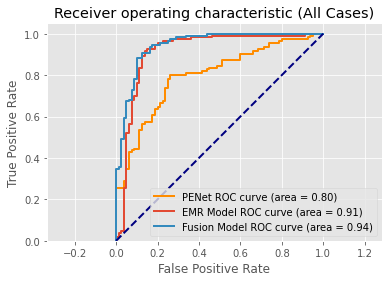

In [18]:
# Performance for all cases
plot_auc(df_test, 'All Cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


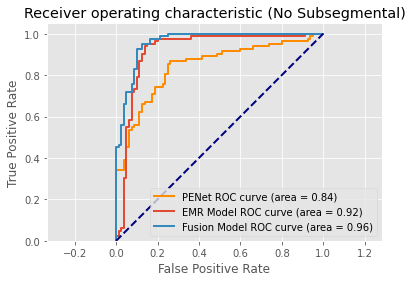

In [19]:
# Performance for non-subsegmental cases
df_test_no_subseg = df_test[df_test[PE_TYPE_COL] != 'subsegmental']
plot_auc(df_test_no_subseg, 'No Subsegmental')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

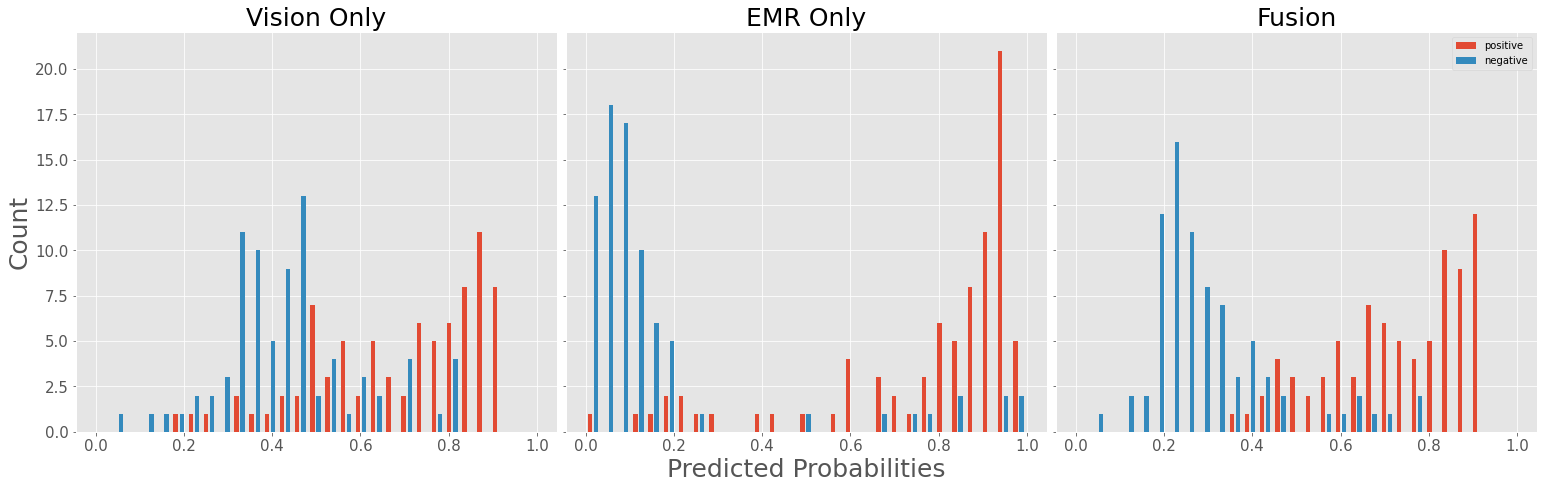

In [20]:
# Visualize histogram of Predicted Probs

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# style
plt.clf()
plt.style.use('ggplot')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(21,6))
bins = np.linspace(0, 1, 30)

# seperate cases into positive and negative
positive_cases = df_test_no_subseg[df_test_no_subseg[LABEL_COL] == 1]
negative_cases = df_test_no_subseg[df_test_no_subseg[LABEL_COL] == 0]

# PENet
ax1.hist(
    [positive_cases[VISION_PRED_COL], negative_cases[VISION_PRED_COL]], 
    bins, 
    label=['positive','negative'], 
    width=0.01)

# EMR
ax2.hist(
    [positive_cases[EMR_PRED_COL], negative_cases[EMR_PRED_COL]], 
    bins, 
    label=['positive', 'negative'], 
    width=0.01)

# Fusion
ax3.hist(
    [positive_cases[FUSION_PRED_COL], negative_cases[FUSION_PRED_COL]], 
    bins, 
    label=['positive','negative'], 
    width=0.01)

f.tight_layout(pad=0.5)
plt.legend(loc='upper right')
ax2.set_xlabel("Predicted Probabilities", fontsize = 25)
ax1.set_ylabel("Count", fontsize = 25)
ax1.set_title('Vision Only', fontsize = 25)
ax2.set_title('EMR Only', fontsize = 25)
ax3.set_title('Fusion', fontsize = 25)
plt.show()